This code is to check how much of Marko's and Hollis's catalogs match with my catalog of potential neighbors around the 9 spectroscopically confirmed QGs. The reason for this code is the fact that there aren't many matches between my catalog and that of Rafael, which is compiled by CIGALE based on Olivier's catalog. A lot of names to keep track of, but they're all related somehow.

(Binh, Sep 25, 2024)

In [2]:
# this sets up basic packages
import numpy as np
import pandas as pd
import astropy.units as u
import astropy.cosmology.units as cu

# this sets up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# this sets up astropy
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord
from astropy.utils.data import get_pkg_data_filename
from astropy.coordinates import SkyCoord, Angle, match_coordinates_sky, Distance
from astropy.table import Table, unique

from regions import Regions, CircleSkyRegion

First, let's load in my catalog.

In [4]:
my_catalog = pd.read_csv('potential_neighbors.txt', sep='\t')

## CHECK 1

### Part 1: Marko's catalog vs. mine

In [7]:
marko = fits.open('/Users/ngbinh/Downloads/check_data/COSMOSWeb_master_v3.1.0_assoc_cold+hot_sersic_cgs_err-calib.fits')
marko_data = Table(marko[1].data)

In [8]:
### matching coords
marko_objects = SkyCoord(ra=marko_data['RA_DETEC'].data*u.degree, dec=marko_data['DEC_DETEC'].data*u.degree)
my_objects = SkyCoord(ra=my_catalog['ra'].values*u.degree, dec=my_catalog['dec'].values*u.degree)

# use search_around_sky to find matching indices (matching in RA and Dec) in each catalog
idx_marko, idx_mine, d2d, d3d = my_objects.search_around_sky(marko_objects, 1*u.arcsec)

In [9]:
# there are going to be cases where one set of coords in my catalog is matched to many sets of coords in Marko's catalog.
# in this part, we're going to find those cases and just select the set of coords with the minimum separation.
my_unique_ids = np.unique(idx_mine)
marko_matches = []
my_matches_with_marko = []
for match in my_unique_ids:
    separations = d2d[np.where(idx_mine == match)]
    if np.size(separations) > 1:
        # this adds the id of the object from Marko's catalog with the minimum separation from my set of coords
        marko_matches.append(idx_marko[np.where(d2d == np.min(separations))][0])
        my_matches_with_marko.append(idx_mine[np.where(d2d == np.min(separations))][0])
    else:
        # this just adds the id of the object from Marko's catalog if there's only one match
        marko_matches.append(idx_marko[np.where(idx_mine == match)][0])
        my_matches_with_marko.append(idx_mine[np.where(idx_mine == match)][0])

In [10]:
print("The number of unique matches with Marko's catalog is", np.size(marko_matches), 'out of', np.size(my_catalog['id'].values))

The number of unique matches with Marko's catalog is 139 out of 155


In [11]:
# these are the objects (rows) in my catalog that aren't in Marko's catalog
catalog_not_in_marko = pd.concat([my_catalog, my_catalog.loc[my_matches_with_marko]]).drop_duplicates(keep=False)
catalog_not_in_marko

,id,ra,dec,host_ra,host_dec
14,780511,150.059862,2.377896,150.061490,2.378680
15,780592,150.060254,2.378310,150.061490,2.378680
16,780808,150.060603,2.379956,150.061490,2.378680
20,780995,150.060525,2.381155,150.061490,2.378680
21,781053,150.061446,2.381259,150.061490,2.378680
34,782969,150.112951,2.377312,150.112560,2.376527
37,783202,150.112071,2.379218,150.112560,2.376527
88,784663,150.087636,2.398937,150.087280,2.396043
95,642465,150.436790,2.466868,150.437320,2.463920
96,642503,150.436177,2.467482,150.437320,2.463920


### Part 2: Marko's catalog vs. Olivier's

In [13]:
# this reads in the file and makes sure the names match the columns
olivier_data = pd.read_csv('/Users/ngbinh/Downloads/check_data/photoz_BC03_v3.1.0_cosmosweb.out', sep=' ').shift(1, axis=1)

In [14]:
olivier_marko_matches, olivier_idx, marko_idx = np.intersect1d(olivier_data['Id'].values, 
                                                                    np.array(marko_matches, dtype='object'), return_indices=True)

In [15]:
# this finds matches between Olivier's catalog and Marko's based on the IDs
olivier_matching_rows = olivier_data[olivier_data['Id'].isin(olivier_marko_matches)]

In [16]:
### Based on the README_flagging TXT file, count/categorize the Olivier-Marko matches based on the flags Olivier gave them.
olivier_flags = olivier_matching_rows['warn_fl'].values

for flag_value in np.unique(olivier_flags):
    flag_no = np.size(np.where(olivier_flags==flag_value))
    print(flag_no, 'objects are flagged', flag_value)

111 objects are flagged 0
25 objects are flagged 1
1 objects are flagged 3


In [17]:
# this retrieves all the objects flagged 1
flagged_ones = olivier_matching_rows[olivier_matching_rows['warn_fl']==1]
flagged_zeros = olivier_matching_rows[olivier_matching_rows['warn_fl']==0]
flagged_ones_ids = flagged_ones['Id'].values # this gets their IDs
flagged_zeros_ids = flagged_zeros['Id'].values # this gets their IDs

In [18]:
# this finds the intersecting elements between flagged_ones and the array of matching IDs from earlier,
# which will allow us to trace the rows in my catalog that correspond to the flagged objects
flags, flagged_idx, marko_idx_narrowed = np.intersect1d(flagged_ones_ids, olivier_marko_matches, return_indices=True)
flags_0, flagged_zeros_idx, marko_idx_zeros = np.intersect1d(flagged_zeros_ids, olivier_marko_matches, return_indices=True)

In [19]:
twenty_five_lephare = my_catalog.iloc[np.array(my_matches_with_marko, dtype='object')[marko_idx[marko_idx_narrowed]]]

In [20]:
the_rest_lephare = my_catalog.iloc[np.array(my_matches_with_marko, dtype='object')[marko_idx[marko_idx_zeros]]]

In [21]:
flagged_ones = flagged_ones.assign(cigale_id=twenty_five_lephare['id'].values.tolist())
flagged_zeros = flagged_zeros.assign(cigale_id=the_rest_lephare['id'].values.tolist())

### Discussion
Based on the README_flagging.txt file, this means that of Marko's <b>139</b> objects that are matchable to my catalog:
- <b>111</b> objects look fine, according to Olivier (flag 0)
- <b>25</b> objects have an offset between ground and space, according to Olivier (flag 1)
- <b>1</b> object has hot pixels, i.e. it has a radius below 1.e-5, according to Olivier (flag 3)

Additionally, there are <b>2</b> objects that are NOT flagged by Olivier at all because they simply just don't show up in Olivier's catalog.

## Update (Oct 22)
We'll move forward with the 111 objects that look fine as our "robust sample".

In [24]:
the_rest_lephare

,id,ra,dec,host_ra,host_dec
89,614117,150.434792,2.462610,150.437320,2.463920
97,614192,150.450922,2.457499,150.454590,2.455994
94,641810,150.439249,2.462442,150.437320,2.463920
90,614284,150.439905,2.462342,150.437320,2.463920
91,614318,150.439453,2.462803,150.437320,2.463920
...,...,...,...,...,...
147,823832,150.112087,2.330083,150.108873,2.330539
153,824112,150.110146,2.332911,150.108873,2.330539
154,824190,150.108294,2.334233,150.108873,2.330539
42,830422,150.116599,2.375749,150.112560,2.376527


In [25]:
# compile a second data frame with the names of the neighbors' host QGs
host_info = pd.read_csv('basic_data.txt', delimiter=' ', names=['host_name', 'host_ra', 'host_dec', 'host_zspec'])

In [26]:
better_df = pd.merge(the_rest_lephare, host_info[['host_ra', 'host_name']], on='host_ra', how='left').sort_values('id')

In [27]:
# this creates an extra data frame with the catalog IDs and the corresponding names we ascribe to each neighbor
# this creates empty lists to add things into
catalog_ids = []
our_names = []
host_idx = []

# this selects the neighbors based on their QG, then adds the suffix 'HX' (hàng xóm) based on the catalog IDs
for w in range(np.size(host_info['host_name'].values)):
    host_name = host_info['host_name'].values[w]
    neighbors = better_df.loc[better_df['host_name'] == host_name]
    for idx in range(np.size(neighbors['id'].values)):
        host_idx.append(w)
        catalog_ids.append(neighbors['id'].values[idx])
        our_names.append(host_name + ' HX' + str(idx + 1))

In [28]:
exhaustive = pd.merge(better_df, pd.DataFrame({'id': catalog_ids, 'our_id': host_idx, 'nbr_name': our_names}), on='id', how='left')
exhaustive.to_csv('robust_set.csv')

## CHECK 2
### Hollis's catalog with mine

In [30]:
hollis = fits.open('/Users/ngbinh/Downloads/check_data/COSMOS-Web_hot+cold_aperture_catalog_v1.3.fits')
hollis_data = Table(hollis[1].data)

In [31]:
### matching coords
hollis_objects = SkyCoord(ra=hollis_data['ra'].data*u.degree, dec=hollis_data['dec'].data*u.degree)

# use search_around_sky to find matching indices (matching in RA and Dec) in each catalog
idx_hollis, idx_mine2, d2d2, d3d2 = my_objects.search_around_sky(hollis_objects, 1*u.arcsec)

In [32]:
# there are going to be cases where one set of coords in my catalog is matched to many sets of coords in Hollis's catalog.
# in this part, we're going to find those cases and just select the set of coords with the minimum separation.
my_unique_ids_2 = np.unique(idx_mine2)
hollis_matches = []
my_matches_with_hollis = []
for match in my_unique_ids_2:
    separations = d2d2[np.where(idx_mine2 == match)]
    if np.size(separations) > 1:
        # this adds the id of the object from Hollis's catalog with the minimum separation from my set of coords
        hollis_matches.append(idx_hollis[np.where(d2d2 == np.min(separations))][0])
        my_matches_with_hollis.append(idx_mine2[np.where(d2d2 == np.min(separations))][0])
    else:
        # this just adds the id of the object from Hollis's catalog if there's only one match
        hollis_matches.append(idx_hollis[np.where(idx_mine2 == match)][0])
        my_matches_with_hollis.append(idx_mine2[np.where(idx_mine2 == match)][0])

In [33]:
print("The number of unique matches with Hollis's catalog is", np.size(hollis_matches), 'out of', np.size(my_catalog['id'].values))

The number of unique matches with Hollis's catalog is 139 out of 155


In [34]:
# these are the objects (rows) in my catalog that aren't in Hollis's catalog
catalog_not_in_hollis = pd.concat([my_catalog, my_catalog.loc[my_matches_with_hollis]]).drop_duplicates(keep=False)
catalog_not_in_hollis

,id,ra,dec,host_ra,host_dec
14,780511,150.059862,2.377896,150.061490,2.378680
15,780592,150.060254,2.378310,150.061490,2.378680
16,780808,150.060603,2.379956,150.061490,2.378680
20,780995,150.060525,2.381155,150.061490,2.378680
21,781053,150.061446,2.381259,150.061490,2.378680
34,782969,150.112951,2.377312,150.112560,2.376527
37,783202,150.112071,2.379218,150.112560,2.376527
88,784663,150.087636,2.398937,150.087280,2.396043
95,642465,150.436790,2.466868,150.437320,2.463920
96,642503,150.436177,2.467482,150.437320,2.463920


## CONCLUSION
There are <b>16</b> objects in my catalog of potential neighbors that are NOT in either Marko's or Hollis's catalog.

In [36]:
# Save the basic info of the 16 outliers
catalog_not_in_hollis.to_csv('16_outliers.txt', sep='\t', index=False)

In [37]:
# Save the basic info of the 25 LePhare objects
twenty_five_lephare.to_csv('25_flag1.txt', sep='\t', index=False)

## Additional checks

Do the LePhare redshifts match with my photometric redshifts from CIGALE?

In [39]:
# this reads in the results FITS file that CIGALE made
cigale_results = fits.open('/Users/ngbinh/quenched/out_all998/results.fits')
cigale_data = Table(cigale_results[1].data).to_pandas()

reduced_cigale_25 = cigale_data.loc[cigale_data['id'].isin(twenty_five_lephare['id'].values)]
reduced_cigale_rest = cigale_data.loc[cigale_data['id'].isin(the_rest_lephare['id'].values)]

In [40]:
my_data_25 = pd.merge(twenty_five_lephare, reduced_cigale_25[['id', 'bayes.universe.redshift']], on="id", how="left")
my_data_rest = pd.merge(the_rest_lephare, reduced_cigale_rest[['id', 'bayes.universe.redshift']], on="id", how="left")

In [41]:
# the photo-zs from my CIGALE runs
my_photozs_25 = my_data_25['bayes.universe.redshift'].values

# the photo-zs from my CIGALE runs
my_photozs_rest = my_data_rest['bayes.universe.redshift'].values

# the photo-zs from LePhare
lephare_stuff_25 = flagged_ones.loc[flagged_ones['cigale_id'].isin(my_data_25['id'].values)]
#lephare_photozs_25 = lephare_stuff_25['zPDF'].values
lephare_photozs_25 = lephare_stuff_25['zChi2'].values

# the photo-zs from LePhare
lephare_stuff_rest = flagged_zeros.loc[flagged_zeros['cigale_id'].isin(my_data_rest['id'].values)]
#lephare_photozs_rest = lephare_stuff_rest['zPDF'].values
lephare_photozs_rest = lephare_stuff_rest['zChi2'].values

Text(0, 0.5, 'LePhare photo-z')

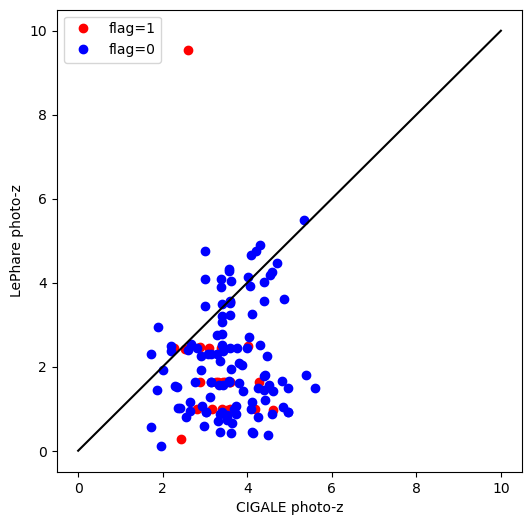

In [42]:
fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(my_photozs_25, lephare_photozs_25, 'o', color='red', label='flag=1')
plt.plot(my_photozs_rest, lephare_photozs_rest, 'o', color='blue', label='flag=0')
plt.plot(np.linspace(0, 10, 1000), np.linspace(0, 10, 1000), color='black')
plt.legend()
plt.xlabel('CIGALE photo-z')
plt.ylabel('LePhare photo-z')

In [43]:
# this reads in the file and makes sure the names match the columns
olivier_mass = pd.read_csv('/Users/ngbinh/Downloads/check_data/mass_BC03_v3.1.0_cosmosweb.out', sep=' ').shift(1, axis=1)
olivier_matching_rows2 = olivier_mass[olivier_mass['Id'].isin(olivier_marko_matches)]
flagged_ones2 = olivier_matching_rows2[olivier_matching_rows['warn_fl']==1]
flagged_ones2 = flagged_ones2.assign(cigale_id=twenty_five_lephare['id'].values.tolist())
lephare_stuff2_25 = flagged_ones2.loc[flagged_ones['cigale_id'].isin(my_data_25['id'].values)]

flagged_zeros2 = olivier_matching_rows2[olivier_matching_rows['warn_fl']==0]
flagged_zeros2 = flagged_zeros2.assign(cigale_id=the_rest_lephare['id'].values.tolist())
lephare_stuff2_rest = flagged_zeros2.loc[flagged_zeros['cigale_id'].isin(my_data_rest['id'].values)]

In [44]:
df1 = pd.merge(lephare_stuff_25[['cigale_id', 'zPDF']], lephare_stuff2_25[['cigale_id', 'mass_med_PDF']], on="cigale_id", how="left")
df2 = pd.merge(lephare_stuff_rest[['cigale_id', 'zPDF']], lephare_stuff2_rest[['cigale_id', 'mass_med_PDF']], on="cigale_id", how="left")

Text(0, 0.5, 'log(LePhare stellar mass)')

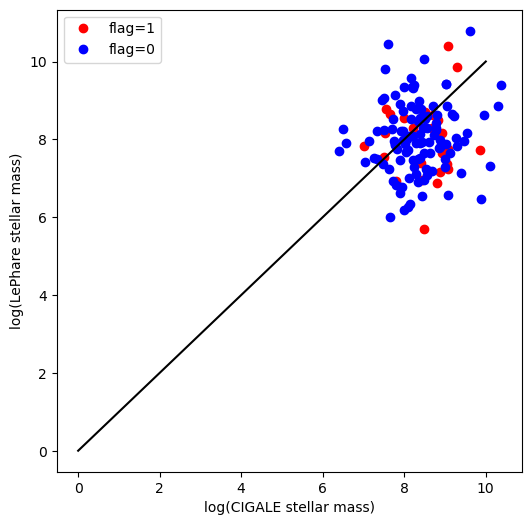

In [45]:
fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(np.log10(reduced_cigale_25['best.stellar.m_star'].values), df1['mass_med_PDF'].values, 'o', color='red', label='flag=1')
plt.plot(np.log10(reduced_cigale_rest['best.stellar.m_star'].values), df2['mass_med_PDF'].values, 'o', color='blue', label='flag=0')
plt.plot(np.log10(np.linspace(1, 1e10, 1000)), np.log10(np.linspace(1, 1e10, 1000)), '-', color='black')
plt.legend()
plt.xlabel('log(CIGALE stellar mass)')
plt.ylabel('log(LePhare stellar mass)')

In [46]:
log_mstar = np.log10(cigale_data[cigale_data['id'].isin(better_df['id'].values)]['bayes.stellar.m_star'].values).tolist()
log_sfr = np.log10(cigale_data[cigale_data['id'].isin(better_df['id'].values)]['bayes.sfh.sfr'].values).tolist()
cigale_mstar_sfr = pd.DataFrame({'log_mstar': log_mstar, 'log_sfr': log_sfr}, columns=['log_mstar', 'log_sfr'])

In [95]:
def log_sfr_rinaldi(log_mstar, alpha, beta):
    return alpha*log_mstar + beta

In [97]:
log_mstar_para = np.arange(3, 13, 0.1)
log_sfr_MS_lowz_rinaldi = log_sfr_rinaldi(log_mstar_para, 0.62, -5.18)
log_sfr_SB_lowz_rinaldi = log_sfr_rinaldi(log_mstar_para, 1.0, -7.29)

In [99]:
import seaborn as sns

<>:3: SyntaxWarning: invalid escape sequence '\o'
<>:4: SyntaxWarning: invalid escape sequence '\o'
<>:3: SyntaxWarning: invalid escape sequence '\o'
<>:4: SyntaxWarning: invalid escape sequence '\o'
/var/folders/td/xh27mb7x6jz3g1splvmtw7z80000gn/T/ipykernel_2816/1776831253.py:3: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('$log_{10}M_*$ $[M_\odot]$', fontsize=22)
/var/folders/td/xh27mb7x6jz3g1splvmtw7z80000gn/T/ipykernel_2816/1776831253.py:4: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('$log_{10}SFR [M_\odot yr^{-1}]$', fontsize=22)


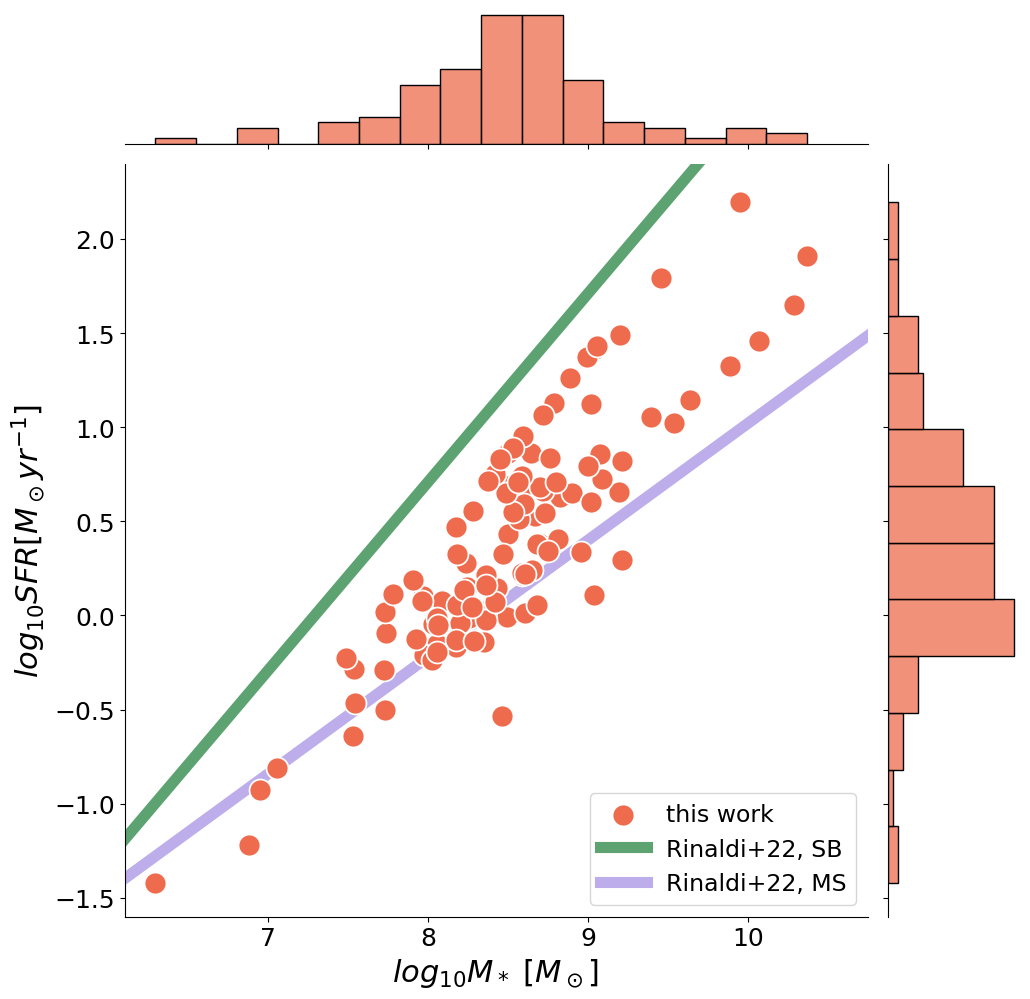

In [107]:
g = sns.jointplot(data = cigale_mstar_sfr, x = 'log_mstar', y = 'log_sfr', height=10, color='#ee6c4d', s=250, 
                  label='this work', zorder=1)
plt.xlabel('$log_{10}M_*$ $[M_\odot]$', fontsize=22)
plt.ylabel('$log_{10}SFR [M_\odot yr^{-1}]$', fontsize=22)

plt.plot(log_mstar_para, log_sfr_SB_lowz_rinaldi, color='#5da271', linewidth=8, 
         label='Rinaldi+22, SB', zorder=0) # jade
plt.plot(log_mstar_para, log_sfr_MS_lowz_rinaldi, color='#bdadea', linewidth=8, 
         label='Rinaldi+22, MS', zorder=0) # wisteria

plt.legend(fontsize = 17, loc='lower right')
plt.tight_layout()
plt.tick_params(axis="both", labelsize=18)
plt.xlim(6.1, 10.75)
plt.ylim(-1.6, 2.4)

fig = g.savefig("mstar_vs_sfr.png") 